In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from IPython.display import display

The function below draws a correlation matrix.

In [34]:
def draw_corr(plot_df, show_annotations=True):
    # Preparing the correlation matrix
    corr = plot_df.corr(numeric_only=True)
    # Calculating the p-values
    pval = (plot_df.corr(
        numeric_only=True,
        method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*corr.shape))
    # Preparing a table of correlations and p-values together
    corr_pval = corr.round(2).astype(str) + '\n(' + pval.round(3).astype(str) + ')'

    # Plotting the correlation matrix and annotating it with the generated table
    plt.figure(figsize=(15,15))
    hm = sns.heatmap(data=corr, 
                    annot=corr_pval if show_annotations else None,
                    fmt = '', 
                    cmap='RdBu_r',
                    mask=np.triu(corr))

# Loading the dataset

In [35]:
df = pd.read_csv("./dataset/01_initial.csv", parse_dates=['date'])

df

,season,date,home,away,home_fulltime_goals,away_fulltime_goals,fulltime_result,home_halftime_goals,away_halftime_goals,halftime_result,...,home_fouls_committed,away_fouls_committed,home_fouls_won,away_fouls_won,home_yellow_cards,away_yellow_cards,home_red_cards,away_red_cards,home_xg,away_xg
0,2017_2018,2017-08-18,Leganes,Alaves,1,0,H,1,0,H,...,17,17,16,17,0,1,0,0,1.3,1.1
1,2017_2018,2017-08-18,Valencia,Las Palmas,1,0,H,1,0,H,...,25,13,13,24,3,2,0,1,1.4,0.2
2,2017_2018,2017-08-19,Celta Vigo,Real Sociedad,2,3,A,1,1,D,...,12,11,10,11,3,1,0,0,1.8,2.1
3,2017_2018,2017-08-19,Girona,Atletico Madrid,2,2,D,2,0,H,...,15,15,14,15,2,4,0,1,2.2,0.7
4,2017_2018,2017-08-19,Sevilla,Espanyol,1,1,D,1,1,D,...,14,12,12,14,2,4,1,0,2.4,1.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2117,2022_2023,2023-02-26,Athletic Bilbao,Girona,2,3,A,1,3,A,...,17,8,7,17,5,5,0,0,1.6,1.2
2118,2022_2023,2023-02-26,Celta Vigo,Real Valladolid,3,0,H,2,0,H,...,6,5,4,6,1,3,0,1,1.8,0.5
2119,2022_2023,2023-02-26,Almeria,Barcelona,1,0,H,1,0,H,...,13,11,11,13,3,3,0,0,1.0,1.1
2120,2022_2023,2023-02-26,Sevilla,Osasuna,2,3,A,0,1,A,...,10,15,15,9,4,2,1,0,2.2,1.0


# Dealing with missing values

The following features contain missing values:

In [36]:
isna_sum = df.isna().sum()
isna_features = isna_sum[isna_sum > 0]

isna_features

home_win_pinnaclesports_probs              3
draw_pinnaclesports_probs                  3
away_win_pinnaclesports_probs              3
home_win_pinnaclesports_closing_probs      1
draw_pinnaclesports_closing_probs          1
away_win_pinnaclesports_closing_probs      1
attendance                               487
dtype: int64

'attendance' (the total number of people attending the venue to watch the match) contains too many missing values and since it cannot be deducted from other features, the best strategy is to drop this feature.

In [37]:
df = df.drop('attendance', axis='columns')

As for the other columns including missing values, since the total number of instances are too few, those instances can safely be dropped.

In [38]:
df = df.dropna(axis='index')

# Preparing the data model

In order to create a panel data model, two component are required:
<ul>
<li>The time component</li>
<li>The cross-sectional component</li>
</ul>

The time component is the date feature of each match; as for the cross-sectional component, each team comprises one section. Hence, the match data will be melted and the data of all the teams will be stacked under each other (rather than next to each other in home/away columns).

## Melt/stack the data

The cell below transforms the dataframe to store all teams stacked under each other (regardless of home/away attributes).

In [39]:
def get_stacked_df(orig_df):
    # Saving the team names temporarily
    orig_df[['temp_home', 'temp_away']] = orig_df[['home', 'away']]

    # All the current columns within the input dataframe
    all_cols = set(orig_df.columns)
    # The Columns to melt
    melting_value_cols = {'home', 'away'}
    # The ID columns to repeat for each melted value
    melting_id_cols = all_cols - melting_value_cols
    # The suffix of the team-specific columns (the column name without the home/away prefix)
    col_suffixes = [col[5:] for col in orig_df.columns if 'away_' in col]
    # Columns related to 'team_1'
    home_cols = [f"home_{col}" for col in col_suffixes]
    # Columns related to 'team_2'
    away_cols = [f"away_{col}" for col in col_suffixes]

    # Putting the melting columns' values into a new column named 'team'
    # Adding a new column 'ground' denoting whether the melted column
    # was home or away
    res = orig_df.melt(
        id_vars=melting_id_cols,
        value_vars=melting_value_cols,
        var_name='ground',
        value_name='team'
    )

    # Setting the opponent's name
    res['opponent'] = res.apply(
        lambda row: row['temp_home'] if row['ground'] == 'away' else row['temp_away'],
        axis='columns'
    )

    # If the melted column was home, add the home related scores into
    # a set of general score columns prefixed by 'own_'; otherwise, add
    # the away related scores.
    res[[f"team_{col}" for col in col_suffixes]] = res.apply(
        lambda row: pd.Series(
            [row[col] for col in home_cols]
            if row['ground'] == 'home' else
            [row[col] for col in away_cols]),
        axis='columns'
    )
    # In either case, add the opponent's attributes into columns suffixed by 'opponent_'
    res[[f"opponent_{col}" for col in col_suffixes]] = res.apply(
        lambda row: pd.Series(
            [row[col] for col in home_cols]
            if row['ground'] == 'away' else
            [row[col] for col in away_cols]),
        axis='columns'
    )

    # Drop the redundant columns (home/away attributes)
    cols_to_drop = home_cols + away_cols + ['temp_home', 'temp_away']
    res = res.drop(cols_to_drop, axis='columns')

    # Returning the newly generated dataframe as output
    return res

df = get_stacked_df(df)

# Converting post-game data to pre-game and computing the First Differance
Currently apart from betting odds, xg and the rating, the rest of the attributes (fouls, goals, passes, ...) are calculated after the game; and since the target of the study is to predict the result of a game that has not happenned yet, only the pre-game metrics and predictors may be used; hence, the post-match data should be replaced with pre-match data.
In that sense, the meaning of the variable 'yellow_cards' will be the total number of the yellow cards the team received within the match preceding the current one.
Since this operation comprises looping over the whole dataset, it is very resource intensive and time consuming; hence, it was decided to embed another data pre-processing step in this loop as well, which is to compute the first differance.

In [40]:
# Sorting the data and creating a refrence dataframe
df_ref = df.sort_values(['season', 'team', 'date']).copy(deep=True)

# Preparing the column lists
col_suffixes = [col[5:] for col in df.columns if (
    (col[:5] == 'team_') and (all(term not in col for term in ['xg', 'rating', 'prob']))
)]
fd_col_suffixes = [col[5:] for col in df.columns if (col[:5] == 'team_')]

ref_cols = [f"team_{col_suffix}" for col_suffix in col_suffixes]
ref_team_fd_cols = [f"team_{col_suffix}" for col_suffix in fd_col_suffixes]
ref_draw_fd_cols = [col for col in df.columns if (col[:5] == 'draw_')]
team_cols = [f"team_{col_suffix}" for col_suffix in col_suffixes]
team_fd_cols = [f"fd_team_{col_suffix}" for col_suffix in fd_col_suffixes]
opponent_cols = [f"opponent_{col_suffix}" for col_suffix in col_suffixes]
opponent_fd_cols = [f"fd_opponent_{col_suffix}" for col_suffix in fd_col_suffixes]
draw_fd_cols = [f"fd_{col}" for col in df.columns if (col[:5] == 'draw_')]

# receives the team name, and returns the first diff of the last two observations before the given date
def get_last_attributes(match_season, match_date, match_team, include_draw=False):
    # Filtering the ref dataframe for team
    filter = ((df_ref['season'] == match_season) &
                (df_ref['date'] < match_date) &
                (df_ref['team'] == match_team))
    df_ref_filtered = df_ref[filter][ref_cols]
    if include_draw:
        df_ref_filtered_fd = df_ref[filter][ref_team_fd_cols + ref_draw_fd_cols].diff(axis='index')
    else:
        df_ref_filtered_fd = df_ref[filter][ref_team_fd_cols].diff(axis='index')
    
    # if it was the team's first two matches of the season, returns None, otherwise returns the first diff
    return (None if (df_ref_filtered.empty or df_ref_filtered_fd.empty) 
            else (list(df_ref_filtered.iloc[-1]) + list(df_ref_filtered_fd.iloc[-1])))

# Going over each row in the dataset
for index, row in df.iterrows():
    cur_season = row['season']
    cur_date = row['date']
    cur_team = row['team']
    cur_opponent = row['opponent']
    
    # Retrieving the team's most recent attributes
    df.loc[index, team_cols + team_fd_cols + draw_fd_cols] = get_last_attributes(cur_season, cur_date, cur_team, include_draw=True)
    
    # Retrieving the opponent's most recent attributes
    df.loc[index, opponent_cols + opponent_fd_cols] = get_last_attributes(cur_season, cur_date, cur_opponent)

# Dropping each team's first two matches of the season (where the pre-match data is None)
df = df.dropna()

# Dropping redundant features

In this step, the primary features will be reviewed and the redundant ones will be dropped.

## Betting odds

The betting odds are gathered from several sources, some of which might correlate very closely; hence, they are analyzed and a candidate subset is selected.

In [41]:
betting_cols = [col 
                for term in ['team_win_', 'draw_', 'opponent_win_'] 
                for col in df.columns if term in col]

betting_cols

['team_win_bet365_probs',
 'team_win_betandwin_probs',
 'team_win_interwetten_probs',
 'team_win_pinnaclesports_probs',
 'team_win_williamhill_probs',
 'team_win_vcbet_probs',
 'team_win_pinnaclesports_closing_probs',
 'fd_team_win_bet365_probs',
 'fd_team_win_betandwin_probs',
 'fd_team_win_interwetten_probs',
 'fd_team_win_pinnaclesports_probs',
 'fd_team_win_williamhill_probs',
 'fd_team_win_vcbet_probs',
 'fd_team_win_pinnaclesports_closing_probs',
 'draw_pinnaclesports_probs',
 'draw_bet365_probs',
 'draw_pinnaclesports_closing_probs',
 'draw_vcbet_probs',
 'draw_betandwin_probs',
 'draw_interwetten_probs',
 'draw_williamhill_probs',
 'fd_draw_pinnaclesports_probs',
 'fd_draw_bet365_probs',
 'fd_draw_pinnaclesports_closing_probs',
 'fd_draw_vcbet_probs',
 'fd_draw_betandwin_probs',
 'fd_draw_interwetten_probs',
 'fd_draw_williamhill_probs',
 'opponent_win_bet365_probs',
 'opponent_win_betandwin_probs',
 'opponent_win_interwetten_probs',
 'opponent_win_pinnaclesports_probs',
 'oppo

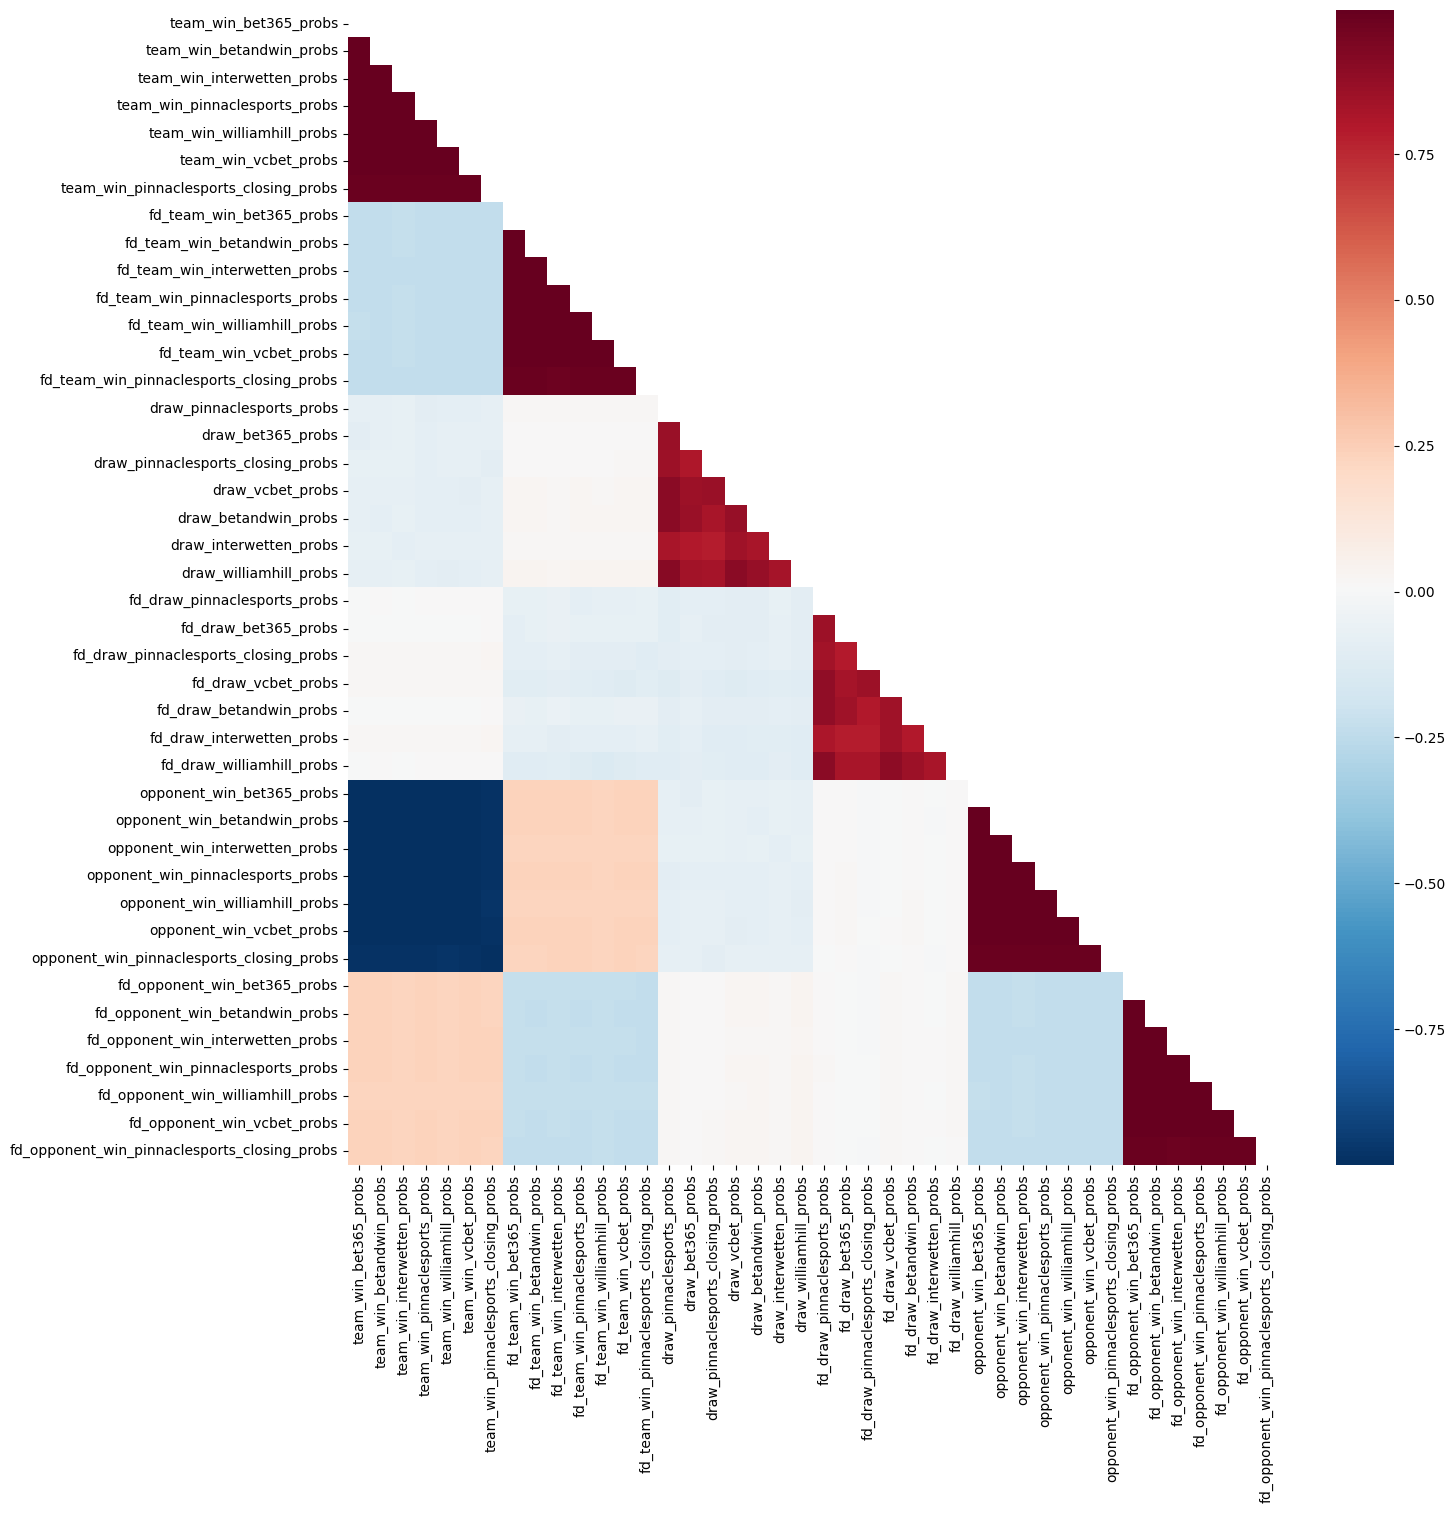

In [42]:
draw_corr(df[betting_cols], show_annotations=False)

As can be seen, each group of betting odds (own_win, draw, and opponent) of every source closely correlates with the same group of every other source; so, taking only one of the sources makes sense as well as simplifies the model.<br>
The data gathered from bet365 will be kept and the rest will be dropped.

In [43]:
df = df.drop([col for col in betting_cols if 'bet365' not in col], axis='columns')

## Ratings

currently there are three rating features for each of the home and away teams:
<ul>
<li>pre_rating</li>
<li>rating_delta</li>
<li>post_rating</li>
</ul>

In [44]:
rating_cols = [col for col in df.columns if 'rating' in col]

rating_cols

['team_pre_rating',
 'team_rating_delta',
 'team_post_rating',
 'opponent_pre_rating',
 'opponent_rating_delta',
 'opponent_post_rating',
 'fd_team_pre_rating',
 'fd_team_rating_delta',
 'fd_team_post_rating',
 'fd_opponent_pre_rating',
 'fd_opponent_rating_delta',
 'fd_opponent_post_rating']

Since the prediction we are about to achieve is based on pre-match attributes, only the pre-rating variable should be saved and the other two may be dropped.

In [45]:
df = df.drop(
    [col for col in rating_cols if 'pre' not in col],
    axis='columns'
)

## String features

String features include the name of the teams as well as the name of the venue where the match was taking place, the fulltime and halftime results, the matches' season, and the ground in which the team was playing (home or away).

In [46]:
df.select_dtypes('object').dtypes

venue              object
halftime_result    object
season             object
fulltime_result    object
ground             object
team               object
opponent           object
dtype: object

In order to use these in the prediction process, they need to be converted into categorical variables and encoded using ordinal or one-hot encoding; however, except for the 'ground' feature, the other sets of features are not closed (new categories might be added in the future) the training can never contain every possible value; hence, these features cannot be used in the model and should be dropped.<br>
The 'team' and 'season' features will later be used for splitting the dataset into train/test sets, the 'ground' and 'fulltime_result' features will be encoded, and the 'halftime_result', 'opponent', and 'venue' features will be dropped right away.

In [47]:
df = df.drop(['venue',
              'opponent',
              'halftime_result'], axis='columns')

# Feature type casting

## Encoding the categorical

The categorical features include the 'fulltime_result' (H/D/A) and the ground (home/away)

In [48]:
df['fulltime_result'].value_counts()

H    1800
A    1118
D    1066
Name: fulltime_result, dtype: int64

In [49]:
# This function encodes the game result as: Win->2, Lose->0, Draw->1 
def encode_result(ground, result):
    if result == 'D':
        return 1
    elif ((result == 'H' and ground == 'home') or (result == 'A' and ground == 'away')):
        return 2
    else:
        return 0

# Going through the whole dataset and encoding the 'fulltime_result' values.
df['fulltime_result'] = df.apply(
    lambda row: encode_result(row['ground'], row['fulltime_result']),
    axis='columns'
)

In [50]:
# Encoding the ground feature as: home->1, away->0
df['ground'] = df['ground'].replace(
    to_replace={
        'away': '0',
        'home': '1',
    }
)

# Renaming the ground feature to accommodate the definition of the values
df = df.rename(columns={
    'ground': 'is_home'
})

## Converting the numerical values to optimal types

In [51]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df.select_dtypes(include=['int', 'float']).dtypes)

draw_bet365_probs                float64
fulltime_result                    int64
team_fulltime_goals              float64
team_halftime_goals              float64
team_win_bet365_probs            float64
team_pre_rating                  float64
team_possession                  float64
team_total_shots                 float64
team_shots_on_target             float64
team_shots_off_target            float64
team_blocked                     float64
team_passing_percent             float64
team_clear_cut_chances           float64
team_corners                     float64
team_offsides                    float64
team_tackles_percent             float64
team_aerial_duels                float64
team_saves                       float64
team_fouls_committed             float64
team_fouls_won                   float64
team_yellow_cards                float64
team_red_cards                   float64
team_xg                          float64
opponent_fulltime_goals          float64
opponent_halftim

The betting features as well as the expected goal metrics are by nature decimal numbers; other than those, the rest of the numerical features should be cast to integer type.

In [52]:
# list of all columns of type float
float_cols = df.select_dtypes(include=['float']).columns

# all float columns except betting odds and XG(s)
columns_to_cast = [col for col in float_cols if all(term not in col for term in ['prob', 'xg'])]

# Casting the selected float columns to integers
for col in columns_to_cast:
    df[col] = df[col].astype('int')

# Duplicate instances

There are no fully duplicated instances in the dataframe.

In [53]:
df[df.duplicated()]

,draw_bet365_probs,date,season,fulltime_result,is_home,team,team_fulltime_goals,team_halftime_goals,team_win_bet365_probs,team_pre_rating,...,fd_opponent_corners,fd_opponent_offsides,fd_opponent_tackles_percent,fd_opponent_aerial_duels,fd_opponent_saves,fd_opponent_fouls_committed,fd_opponent_fouls_won,fd_opponent_yellow_cards,fd_opponent_red_cards,fd_opponent_xg


There are also no duplicate instances where any two teams with the same attributes go against each other, regardless of the game result and number of scored goals.

In [54]:
dup_cols = [col for col in df.columns if (
    (col not in ['season', 'date', 'team', 'away', 'fulltime_result']) and
    ('goals' not in col)
)]
df[df.duplicated(subset=dup_cols)][dup_cols]

,draw_bet365_probs,is_home,team_win_bet365_probs,team_pre_rating,team_possession,team_total_shots,team_shots_on_target,team_shots_off_target,team_blocked,team_passing_percent,...,fd_opponent_corners,fd_opponent_offsides,fd_opponent_tackles_percent,fd_opponent_aerial_duels,fd_opponent_saves,fd_opponent_fouls_committed,fd_opponent_fouls_won,fd_opponent_yellow_cards,fd_opponent_red_cards,fd_opponent_xg


Duplicate analysis in regular columns (not the first differances) also returns empty.

In [55]:
dup_cols_regular = [col for col in df.columns if (
    (col not in ['season', 'date', 'team', 'away', 'fulltime_result']) and
    ('goals' not in col) and
    (col[:3] != 'fd_')
)]
df[df.duplicated(subset=dup_cols_regular)][dup_cols_regular]

,draw_bet365_probs,is_home,team_win_bet365_probs,team_pre_rating,team_possession,team_total_shots,team_shots_on_target,team_shots_off_target,team_blocked,team_passing_percent,...,opponent_corners,opponent_offsides,opponent_tackles_percent,opponent_aerial_duels,opponent_saves,opponent_fouls_committed,opponent_fouls_won,opponent_yellow_cards,opponent_red_cards,opponent_xg


Duplicate analysis in first-differance columns returns empty as well.

In [56]:
dup_cols_fd = [col for col in df.columns if (
    (col not in ['season', 'date', 'team', 'away', 'fulltime_result']) and
    ('goals' not in col) and
    (col[:3] == 'fd_')
)]
df[df.duplicated(subset=dup_cols_fd)][dup_cols_fd]

,fd_team_win_bet365_probs,fd_team_pre_rating,fd_team_possession,fd_team_total_shots,fd_team_shots_on_target,fd_team_shots_off_target,fd_team_blocked,fd_team_passing_percent,fd_team_clear_cut_chances,fd_team_corners,...,fd_opponent_corners,fd_opponent_offsides,fd_opponent_tackles_percent,fd_opponent_aerial_duels,fd_opponent_saves,fd_opponent_fouls_committed,fd_opponent_fouls_won,fd_opponent_yellow_cards,fd_opponent_red_cards,fd_opponent_xg


# Outlier identification

In [58]:
from IPython.display import display
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df.describe()) 

,draw_bet365_probs,fulltime_result,team_fulltime_goals,team_halftime_goals,team_win_bet365_probs,team_pre_rating,team_possession,team_total_shots,team_shots_on_target,team_shots_off_target,team_blocked,team_passing_percent,team_clear_cut_chances,team_corners,team_offsides,team_tackles_percent,team_aerial_duels,team_saves,team_fouls_committed,team_fouls_won,team_yellow_cards,team_red_cards,team_xg,opponent_fulltime_goals,opponent_halftime_goals,opponent_win_bet365_probs,opponent_pre_rating,opponent_possession,opponent_total_shots,opponent_shots_on_target,opponent_shots_off_target,opponent_blocked,opponent_passing_percent,opponent_clear_cut_chances,opponent_corners,opponent_offsides,opponent_tackles_percent,opponent_aerial_duels,opponent_saves,opponent_fouls_committed,opponent_fouls_won,opponent_yellow_cards,opponent_red_cards,opponent_xg,fd_team_fulltime_goals,fd_team_halftime_goals,fd_team_win_bet365_probs,fd_team_pre_rating,fd_team_possession,fd_team_total_shots,fd_team_shots_on_target,fd_team_shots_off_target,fd_team_blocked,fd_team_passing_percent,fd_team_clear_cut_chances,fd_team_corners,fd_team_offsides,fd_team_tackles_percent,fd_team_aerial_duels,fd_team_saves,fd_team_fouls_committed,fd_team_fouls_won,fd_team_yellow_cards,fd_team_red_cards,fd_team_xg,fd_draw_bet365_probs,fd_opponent_fulltime_goals,fd_opponent_halftime_goals,fd_opponent_win_bet365_probs,fd_opponent_pre_rating,fd_opponent_possession,fd_opponent_total_shots,fd_opponent_shots_on_target,fd_opponent_shots_off_target,fd_opponent_blocked,fd_opponent_passing_percent,fd_opponent_clear_cut_chances,fd_opponent_corners,fd_opponent_offsides,fd_opponent_tackles_percent,fd_opponent_aerial_duels,fd_opponent_saves,fd_opponent_fouls_committed,fd_opponent_fouls_won,fd_opponent_yellow_cards,fd_opponent_red_cards,fd_opponent_xg
count,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000
mean,0.355979,1.000000,1.271335,0.553464,0.322041,1986.616215,49.545934,11.670934,4.034137,4.870482,2.766315,77.275853,1.413655,4.716867,2.199548,60.897590,49.585090,2.764809,13.512048,12.744227,2.410894,0.116717,1.278012,1.271335,0.553464,0.322041,1986.616215,49.545934,11.670934,4.034137,4.870482,2.766315,77.275853,1.413655,4.716867,2.199548,60.897590,49.585090,2.764809,13.512048,12.744227,2.410894,0.116717,1.278012,0.005773,0.005522,-0.000078,0.025351,-0.007279,0.013303,0.011044,-0.003765,0.006024,0.009287,0.005522,0.008032,0.008283,0.009789,0.001004,0.004769,-0.046687,-0.049448,0.003012,0.000251,0.003363,0.000309,0.005773,0.005522,-0.000078,0.025351,-0.007279,0.013303,0.011044,-0.003765,0.006024,0.009287,0.005522,0.008032,0.008283,0.009789,0.001004,0.004769,-0.046687,-0.049448,0.003012,0.000251,0.003363
std,0.028776,0.855929,1.178271,0.760996,0.151131,130.855932,11.562508,4.721083,2.325581,2.615889,2.016467,8.327707,1.342473,2.682581,1.761470,13.871222,10.622067,1.874993,4.121535,4.023231,1.469445,0.341581,0.770123,1.178271,0.760996,0.151131,130.855932,11.562508,4.721083,2.325581,2.615889,2.016467,8.327707,1.342473,2.68

The code below provides two approaches to identify the outliers:
<ul>
<li>z-score with the threshold of 3</li>
<li>inter-quartile range (IQR) method</li>
</ul>

In [59]:
def outlier_analysis_zscore(df, col):
    threshold = 3
    col_mean = round(df[col].mean(), 2)
    col_std = round(df[col].std(), 2)
    upper_limit = round(col_mean + threshold * col_std, 2)
    lower_limit = round(col_mean - threshold * col_std, 2)
    col_filtered = df[(lower_limit > df[col]) | (df[col] > upper_limit)]
    return col_filtered.index

def outlier_analysis_iqr(df, col):
    q1=df[col].quantile(0.25)
    q3=df[col].quantile(0.75)
    iqr=q3-q1
    col_filtered = df[(df[col] < (q1-1.5*iqr)) | (df[col] > (q3+1.5*iqr))]
    return col_filtered.index

Outlier detection should be restricted to train/validation data and not the test data; hence, a filtered version of the data set is used for this stage.

In [60]:
df_ol = df[df['season'] != '2022_2023']

First the dataset is saved into file and imported into IBM SPSS to perform normal distribution analysis.

In [61]:
df_ol.to_csv("./dataset/02_outlier_analysis.csv", index=False)

According to Shapiro-Wilk normality test run using SPSS, the following columns are very close to normal distribution:
<ul>
<li>fd_team_possession
<li>fd_opponent_possession
<li>fd_team_aerial_duels
<li>fd_opponent_aerial_duels
<li>team_aerial_duels
<li>opponent_aerial_duels
<li>fd_team_tackles_percent
<li>fd_opponent_tackles_percent
<li>fd_team_fouls_won
<li>fd_opponent_fouls_won
<li>fd_team_total_shots
<li>fd_opponent_total_shots
<li>team_possession
<li>opponent_possession
<li>fd_team_fouls_committed
<li>fd_opponent_fouls_committed
<li>fd_team_win_bet365_probs
<li>fd_opponent_win_bet365_probs
<li>team_tackles_percent
<li>opponent_tackles_percent
<li>fd_team_xg
<li>fd_opponent_xg
<li>fd_team_corners
<li>fd_opponent_corners
<li>fd_team_pre_rating
<li>fd_opponent_pre_rating
<li>fd_team_shots_off_target
<li>fd_opponent_shots_off_target
<li>fd_draw_bet365_probs
<li>fd_team_shots_on_target
<li>fd_opponent_shots_on_target
<li>team_fouls_committed
<li>opponent_fouls_committed
<li>team_fouls_won
<li>opponent_fouls_won
<li>fd_team_blocked
<li>fd_opponent_blocked
<li>fd_team_saves
<li>fd_opponent_saves
<li>team_win_bet365_probs
</ul>

In [62]:
outlier_cols = [col for col in df_ol.select_dtypes(include=['int', 'float']).columns]
normal_cols = [
    'fd_team_possession',
    'fd_opponent_possession',
    'fd_team_aerial_duels',
    'fd_opponent_aerial_duels',
    'team_aerial_duels',
    'opponent_aerial_duels',
    'fd_team_tackles_percent',
    'fd_opponent_tackles_percent',
    'fd_team_fouls_won',
    'fd_opponent_fouls_won',
    'fd_team_total_shots',
    'fd_opponent_total_shots',
    'team_possession',
    'opponent_possession',
    'fd_team_fouls_committed',
    'fd_opponent_fouls_committed',
    'fd_team_win_bet365_probs',
    'fd_opponent_win_bet365_probs',
    'team_tackles_percent',
    'opponent_tackles_percent',
    'fd_team_xg',
    'fd_opponent_xg',
    'fd_team_corners',
    'fd_opponent_corners',
    'fd_team_pre_rating',
    'fd_opponent_pre_rating',
    'fd_team_shots_off_target',
    'fd_opponent_shots_off_target',
    'fd_draw_bet365_probs',
    'fd_team_shots_on_target',
    'fd_opponent_shots_on_target',
    'team_fouls_committed',
    'opponent_fouls_committed',
    'team_fouls_won',
    'opponent_fouls_won',
    'fd_team_blocked',
    'fd_opponent_blocked',
    'fd_team_saves',
    'fd_opponent_saves',
    'team_win_bet365_probs',
]

In [63]:
all_outlier_indices = set()

for col in outlier_cols:
    col_outlier_indices = set(outlier_analysis_zscore(df_ol, col)) if col in normal_cols else set(outlier_analysis_iqr(df_ol, col))
    all_outlier_indices = all_outlier_indices.union(col_outlier_indices)
    if len(col_outlier_indices) > 0:
        print(col, '\n', '-'*30)
        print(f"values:\n{df_ol.loc[list(col_outlier_indices)][col].value_counts().sort_index()}\n")

draw_bet365_probs 
 ------------------------------
values:
0.23     2
0.24     4
0.26     6
0.27    26
0.44     6
Name: draw_bet365_probs, dtype: int64

team_fulltime_goals 
 ------------------------------
values:
6    13
7     1
8     1
Name: team_fulltime_goals, dtype: int64

team_halftime_goals 
 ------------------------------
values:
3    60
4    11
5     2
Name: team_halftime_goals, dtype: int64

team_pre_rating 
 ------------------------------
values:
2287    2
2288    2
2289    1
2290    3
2291    1
       ..
2397    1
2400    1
2401    1
2403    1
2406    1
Name: team_pre_rating, Length: 65, dtype: int64

team_total_shots 
 ------------------------------
values:
24    18
25    13
26     5
27     8
28     4
29     4
30     2
32     2
33     1
36     1
Name: team_total_shots, dtype: int64

team_shots_on_target 
 ------------------------------
values:
10    33
11    25
12    10
13     2
14     6
16     1
17     1
Name: team_shots_on_target, dtype: int64

team_shots_off_target 
 --

Now, the outlier values are observed to select the annomalities, which are then dropped from the dataset.

In [64]:
outlier_vals_team = (
    (df_ol['team_fulltime_goals'] >= 7) |
    (df_ol['team_halftime_goals'] == 5) |
    (df_ol['team_total_shots'] >= 33) |
    (df_ol['team_shots_on_target'] >= 16) |
    (df_ol['team_shots_off_target'] > 15) |
    (df_ol['team_blocked'] >= 12) |
    (df_ol['team_passing_percent'] < 50) |
    (df_ol['team_clear_cut_chances'] >= 8) |
    (df_ol['team_corners'] >= 15) |
    (df_ol['team_offsides'] >= 10) |
    (df_ol['team_tackles_percent'] < 19) |
    (df_ol['team_aerial_duels'] <= 17) |
    (df_ol['team_aerial_duels'] > 81) |
    (df_ol['team_saves'] >= 11) |
    (df_ol['team_fouls_committed'] > 28) |
    (df_ol['team_fouls_committed'] <= 1) |
    (df_ol['team_fouls_won'] == 0) |
    (df_ol['team_fouls_won'] >= 27) |
    (df_ol['team_yellow_cards'] == 8) |
    (df_ol['team_red_cards'] == 3) |
    (df_ol['team_xg'] > 4.2)
)
outlier_vals_opponent = (
    (df_ol['opponent_fulltime_goals'] >= 7) |
    (df_ol['opponent_halftime_goals'] == 5) |
    (df_ol['opponent_total_shots'] >= 33) |
    (df_ol['opponent_shots_on_target'] >= 16) |
    (df_ol['opponent_shots_off_target'] > 15) |
    (df_ol['opponent_blocked'] >= 12) |
    (df_ol['opponent_passing_percent'] < 50) |
    (df_ol['opponent_clear_cut_chances'] >= 8) |
    (df_ol['opponent_corners'] >= 15) |
    (df_ol['opponent_offsides'] >= 10) |
    (df_ol['opponent_tackles_percent'] < 19) |
    (df_ol['opponent_aerial_duels'] <= 17) |
    (df_ol['opponent_aerial_duels'] > 81) |
    (df_ol['opponent_saves'] >= 11) |
    (df_ol['opponent_fouls_committed'] > 28) |
    (df_ol['opponent_fouls_committed'] <= 1) |
    (df_ol['opponent_fouls_won'] == 0) |
    (df_ol['opponent_fouls_won'] >= 27) |
    (df_ol['opponent_yellow_cards'] == 8) |
    (df_ol['opponent_red_cards'] == 3) |
    (df_ol['opponent_xg'] > 4.2)
)
outlier_vals_fd_team = (
    (df_ol['fd_team_fulltime_goals'] == -6) |
    (df_ol['fd_team_fulltime_goals'] == 7) |
    (df_ol['fd_team_halftime_goals'] == -5) |
    (df_ol['fd_team_halftime_goals'] == 5) |
    (df_ol['fd_team_pre_rating'] >= 34) |
    (df_ol['fd_team_pre_rating'] <= -34) |
    (df_ol['fd_team_possession'] >= 41) |
    (df_ol['fd_team_possession'] <= -41) |
    (df_ol['fd_team_total_shots'] >= 23) |
    (df_ol['fd_team_shots_on_target'] <= -11) |
    (df_ol['fd_team_shots_on_target'] >= 11) |
    (df_ol['fd_team_shots_off_target'] == -13) |
    (df_ol['fd_team_shots_off_target'] >= 12) |
    (df_ol['fd_team_blocked'] == -13) |
    (df_ol['fd_team_blocked'] >= 10) |
    (df_ol['fd_team_passing_percent'] <= -27) |
    (df_ol['fd_team_passing_percent'] >= 27) |
    (df_ol['fd_team_clear_cut_chances'] == -8) |
    (df_ol['fd_team_corners'] == -14) |
    (df_ol['fd_team_corners'] == 14) |
    (df_ol['fd_team_offsides'] <= -9) |
    (df_ol['fd_team_offsides'] >= 10) |
    (df_ol['fd_team_tackles_percent'] < -56) |
    (df_ol['fd_team_tackles_percent'] >= 60) |
    (df_ol['fd_team_aerial_duels'] <= -42) |
    (df_ol['fd_team_aerial_duels'] >= 42) |
    (df_ol['fd_team_saves'] <= -10) |
    (df_ol['fd_team_saves'] >= 12) |
    (df_ol['fd_team_fouls_committed'] <= -17) |
    (df_ol['fd_team_fouls_committed'] >= 19) |
    (df_ol['fd_team_fouls_won'] <= -19) |
    (df_ol['fd_team_fouls_won'] == 18) |
    (df_ol['fd_team_yellow_cards'] <= -7) |
    (df_ol['fd_team_red_cards'] == -3) |
    (df_ol['fd_team_red_cards'] == 3) |
    (df_ol['fd_team_xg'] <= -3.1) |
    (df_ol['fd_team_xg'] >= 3.1)
)
outlier_vals_fd_opponent = (
    (df_ol['fd_opponent_fulltime_goals'] == -6) |
    (df_ol['fd_opponent_fulltime_goals'] == 7) |
    (df_ol['fd_opponent_halftime_goals'] == -5) |
    (df_ol['fd_opponent_halftime_goals'] == 5) |
    (df_ol['fd_opponent_pre_rating'] >= 34) |
    (df_ol['fd_opponent_pre_rating'] <= -34) |
    (df_ol['fd_opponent_possession'] >= 41) |
    (df_ol['fd_opponent_possession'] <= -41) |
    (df_ol['fd_opponent_total_shots'] >= 23) |
    (df_ol['fd_opponent_shots_on_target'] <= -11) |
    (df_ol['fd_opponent_shots_on_target'] >= 11) |
    (df_ol['fd_opponent_shots_off_target'] == -13) |
    (df_ol['fd_opponent_shots_off_target'] >= 12) |
    (df_ol['fd_opponent_blocked'] == -13) |
    (df_ol['fd_opponent_blocked'] >= 10) |
    (df_ol['fd_opponent_passing_percent'] <= -27) |
    (df_ol['fd_opponent_passing_percent'] >= 27) |
    (df_ol['fd_opponent_clear_cut_chances'] == -8) |
    (df_ol['fd_opponent_corners'] == -14) |
    (df_ol['fd_opponent_corners'] == 14) |
    (df_ol['fd_opponent_offsides'] <= -9) |
    (df_ol['fd_opponent_offsides'] >= 10) |
    (df_ol['fd_opponent_tackles_percent'] < -56) |
    (df_ol['fd_opponent_tackles_percent'] >= 60) |
    (df_ol['fd_opponent_aerial_duels'] <= -42) |
    (df_ol['fd_opponent_aerial_duels'] >= 42) |
    (df_ol['fd_opponent_saves'] <= -10) |
    (df_ol['fd_opponent_saves'] >= 12) |
    (df_ol['fd_opponent_fouls_committed'] <= -17) |
    (df_ol['fd_opponent_fouls_committed'] >= 19) |
    (df_ol['fd_opponent_fouls_won'] <= -19) |
    (df_ol['fd_opponent_fouls_won'] == 18) |
    (df_ol['fd_opponent_yellow_cards'] <= -7) |
    (df_ol['fd_opponent_red_cards'] == -3) |
    (df_ol['fd_opponent_red_cards'] == 3) |
    (df_ol['fd_opponent_xg'] <= -3.1) |
    (df_ol['fd_opponent_xg'] >= 3.1)
)

outlier_vals = outlier_vals_team | outlier_vals_opponent | outlier_vals_fd_team | outlier_vals_fd_opponent

# Excluding the last season's matches from outlier deletion since it will not be incorporated into training the model
outlier_rows = df_ol[(outlier_vals) & (df_ol['season'] != '2022_2023')]

df = df.drop(outlier_rows.index, axis='index')

print(f"{outlier_rows.shape[0]} observations were dropped due to being outliers.")

384 observations were dropped due to being outliers.


# Feature selection

In this section the correlation of the features with the target variable are analyzed and uncorrelated features are dropped.

First the dataset is saved into file and imported into IBM SPSS to perform correlation analysis.

In [37]:
df.to_csv("./dataset/03_feature_selection.csv", index=False)

## Selection of features for regular model

In [203]:
# TODO: Perform correlation analysis for normal team/opponent features and the target variable

## Selection of features for panel data model

In [204]:
# TODO: Perform correlation analysis for First Differance features and the target variable

# Storing the cleaned dataset

The final dataset is saved into file in order to later be used to train/test the machine learning models.

In [205]:
df.to_csv("./dataset/04_matches_cleaned.csv", index=False)